<h1>Data input</h1>

Begin by importing the help functions in the 'proto' package:

In [1]:
import fit_functions

Define data files: 
 - spectrum: simple 3-column ASCII file
 - wavelength regions to be ignored by fit: simple 2-column ASCII file
 - model to be fitted: ASCII file in specfit's IRAF database format.

In [2]:
datafile = "../data/n5548/n5548_mean_g130mb4.asc"
regionsfile = "../data/n5548/n5548_lyalpha_sample.dat"
modelfile = "../data/n5548/sfn5548_lyalpha_all_first.dat"

Read spectrum and regions files. 

Spectrum is returned as an object that encapsulates wavelength, flux, and error arrays. 

Mask is a float numpy array with 1's for good data points and 0's for ignored data points.

In [3]:
spectrum, mask = fit_functions.read_file(datafile, regions=regionsfile)

Read model:

In [4]:
model = fit_functions.read_model(modelfile)

Model is a list of functions defined in astropy.modeling.models. 

In [5]:
print(model)

[<powerlaw(amplitude=5.5862e-14, x_0=1000.0, alpha=0.3819233)>, <gaussian(amplitude=5.470799789903966e-15, mean=1195.006, stddev=1.4582876921803867)>, <gaussian(amplitude=3.832878204362091e-15, mean=1226.392, stddev=1.4965886023906898)>, <gaussian(amplitude=1.8002330201750468e-13, mean=1236.729, stddev=0.44759650054727335)>, <gaussian(amplitude=1.447748614901618e-13, mean=1235.996, stddev=1.5083085393581195)>, <gaussian(amplitude=1.4612891678165536e-13, mean=1235.138, stddev=5.319795275438528)>, <gaussian(amplitude=8.875446949581156e-14, mean=1231.589, stddev=14.18872702134092)>, <gaussian(amplitude=1.9230780282067878e-14, mean=1237.643, stddev=31.87861608879444)>, <gaussian(amplitude=1.0655911583717979e-14, mean=1259.753, stddev=0.4559293380796675)>, <gaussian(amplitude=1.062176350691007e-14, mean=1263.803, stddev=0.45739511257611476)>, <gaussian(amplitude=1.6141362281095466e-15, mean=1259.533, stddev=1.5370311712200933)>, <gaussian(amplitude=1.6089639182890395e-15, mean=1263.582, std

<h1>Fitting</h1>

So far, we have worked on having the data ingested into appropriate formats acceptable by the astropy fitting stuff.

Now, to fit the multiple components in the model simultaneously, we have to build a compound model. An astropy compound model is just a combination of all the functions in the model, using as combination operators such things as additin, multiplication, and others.

Example: 

<code>compound_model = models.PowerLaw1D(1.,1.) + models.Gaussian1D(1.,1.,1.)</code>

will create an instance of a compound model with two components.

We build our component model by calling a function in the fit_functions module that will just add together all the functions in the input list:

In [6]:
compound_model = fit_functions.compoundModel(model)

In [7]:
print(compound_model)

Model: CompoundModel19
Inputs: (u'x',)
Outputs: (u'y',)
Model set size: 1
Parameters:
    amplitude_0 x_0_0   alpha_0  ...    amplitude_20    mean_20    stddev_20  
    ----------- ------ --------- ... ------------------ -------- -------------
     5.5862e-14 1000.0 0.3819233 ... -5.40467714014e-15 1262.044 6.58430311862





The actual fitting then is a very simple operation. 

First, we instantiate a fitter engine:

In [8]:
import astropy.modeling.fitting as fitting

In [9]:
fitter = fitting.LevMarLSQFitter()

In this example, we have errors for the data points, so we can use their inverse as weights for the fit:

In [10]:
w = mask / spectrum.e.data

And rhe fit itself is made by just calling the fitter instance with the data, weights, and some control parameters if needed:

In [11]:
fit_result = fitter(compound_model, spectrum.x.data, spectrum.y.data, weights=w, acc=1.E-6, maxiter=1000)

The warning is something generated by astropy. Seems to be harmless in this case.

And the result is another instance of a compound model, with the fitted values set into the  parameter values:

In [12]:
print(fit_result)

Model: CompoundModel19
Inputs: (u'x',)
Outputs: (u'y',)
Model set size: 1
Parameters:
    amplitude_0 x_0_0   alpha_0  ...    amplitude_20    mean_20    stddev_20  
    ----------- ------ --------- ... ------------------ -------- -------------
     5.5862e-14 1000.0 0.3819233 ... -5.40467714014e-15 1262.044 6.58430311862


In [13]:
import matplotlib.pyplot as plt

In [14]:
%matplotlib inline

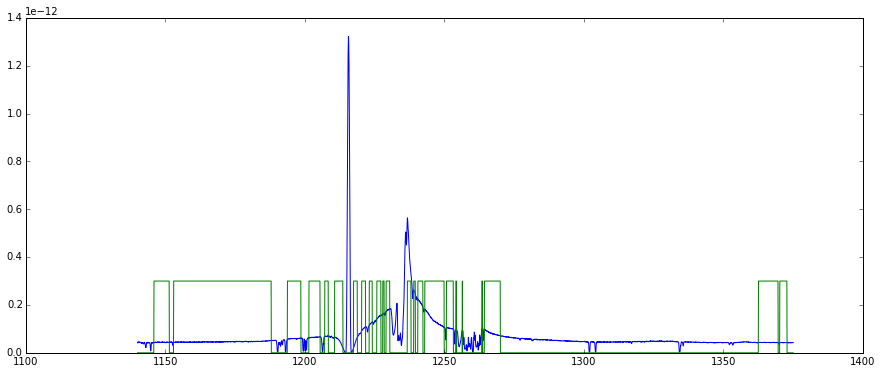

In [20]:
plt.gcf().set_size_inches(15.,6.)
plt.plot(spectrum.x.data, spectrum.y.data, 'b')
plt.plot(spectrum.x.data, mask*3.E-13, 'g')

In [21]:
model_y = fit_result(spectrum.x.data)

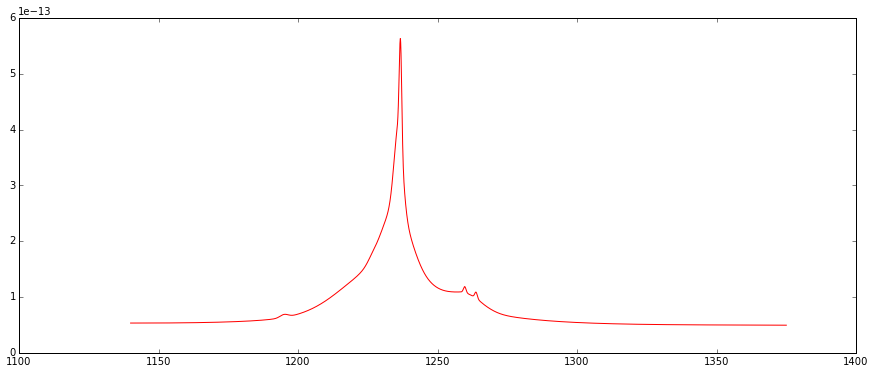

In [22]:
plt.gcf().set_size_inches(15.,6.)
plt.plot(spectrum.x.data, model_y, 'r')

In [24]:
residuals = spectrum.y.data - model_y

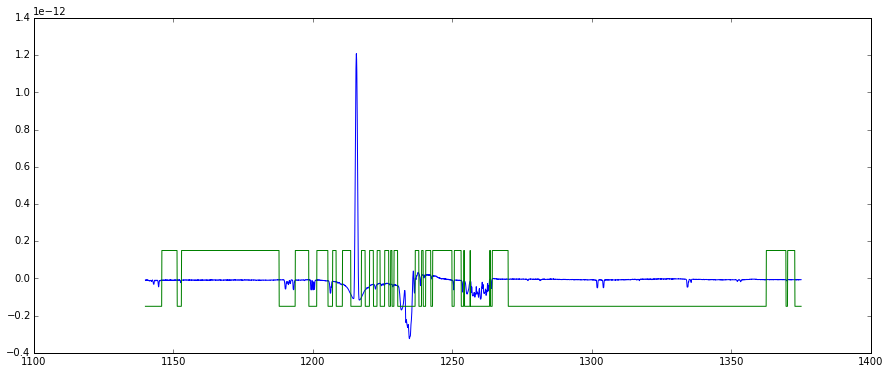

In [31]:
plt.gcf().set_size_inches(15.,6.)
plt.plot(spectrum.x.data, residuals, 'b')
plt.plot(spectrum.x.data, (mask-0.5)*3.E-13, 'g')